Step 1) Add stints

Step 2) Remove fuel, create fuel corrected laps 

Step 3) Remove laps 5% outside fastest

Step 4) Normalise by taking away fastest lap

Step 5) Curves on normalised laps (try number of total laps (practice + quali inc.) and try number of laps since fitting)


\
\
2 other ideas:

1) For each stint do its own curve then average the curves

2) Average out the normalised laptimes for the same lap, so say average all the lap 1 times and then curve from that

\
\
Need to test if actually better using individual drivers or just to average over all drivers. Test with a whole season

In [52]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../")))
from DB.models import init_db, Circuit, Season, RacingWeekend, Driver, Session, SessionResult, Lap


def create_dataframe():
	# Initialize db connection and session
	db_engine, db_session = init_db()

	# Query data from the database
	query = db_session.query(
		RacingWeekend.year,
		RacingWeekend.round,
		Circuit.circuit_name,
		Driver.driver_name,
		Driver.driver_short,
		Lap.lap_num,
		Lap.lap_time,
		Lap.tyre,
		Lap.tyre_laps,
		Lap.pit,
		Session.session_type
	).join(RacingWeekend.circuit) \
	 .join(RacingWeekend.sessions) \
	 .join(Session.laps) \
	 .join(Lap.driver) \
	 .join(RacingWeekend.season) \
	 .all()

	# Convert result to list of dicts
	data = []
	for row in query:
		data.append({
			'year': row.year,
			'round': row.round,
			'circuit_name': row.circuit_name,
			'driver_name': row.driver_name,
			'driver_short': row.driver_short,
			'lap_num': row.lap_num,
			'lap_time': row.lap_time,
			'tyre': row.tyre,
			'tyre_laps': row.tyre_laps,
			'pit': row.pit,
			'session_type': row.session_type
		})

	# Create DataFrame
	df = pd.DataFrame(data)
	return df
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.width', None)  # Auto-detect the display width
pd.set_option('display.max_colwidth', None)  # Display full content of each column

df = create_dataframe()
df = df[(df['year'] == 2022) & (df['round'] == 1)]

## Step 1) Add stints 

In [53]:
def assign_stint_numbers(df):
	# Assign stint numbers to laps based on pit stops for each driver
	df['stint'] = np.nan
	for driver in df['driver_short'].unique():
		driver_data = df[df['driver_short'] == driver]
		stint_number = 1
		for i in driver_data.index:
			if driver_data.loc[i, 'pit'] and i != driver_data.index[0]:
				stint_number += 1
			df.loc[i, 'stint'] = stint_number
	df['stint'] = df['stint'].astype(int)
	return df


df = assign_stint_numbers(df[df['session_type'] == 'Race'])

/tmp/ipykernel_2865/219913496.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stint'] = np.nan
/tmp/ipykernel_2865/219913496.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stint'] = df['stint'].astype(int)


## Step 2) Fuel corrected laptime

In [54]:
def correct_fuel_effect(df, max_fuel_kg=110, fuel_effect_per_kg=0.03):
	# Find the maximum number of laps completed by any driver in the race
	max_laps_race = df['lap_num'].max()

	# Group by driver to process each driver's laps individually
	def _correct_fuel_for_driver(driver_df):
		driver_df['fuel_weight'] = max_fuel_kg - (driver_df['lap_num'] - 1) * (max_fuel_kg / max_laps_race)
		driver_df['fuel_correction'] = driver_df['fuel_weight'] * fuel_effect_per_kg
		driver_df['fuel_corrected_lap_time'] = driver_df['lap_time'] - driver_df['fuel_correction']
		return driver_df

	# Apply the correction to each driver's laps
	df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)
	return df

df = correct_fuel_effect(df)

/tmp/ipykernel_2865/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)


## Step 3) Remove laps not within 5% of fastest

In [55]:
def remove_laps_outside_percent(df, percentage=5):
	"""
	Remove laps that are not within the specified percentage of the fastest lap time for each driver.

	Parameters:
		df (pd.DataFrame): The DataFrame containing lap data for the full race.
		percentage (float): The percentage threshold (default: 5%).

	Returns:
		pd.DataFrame: DataFrame with laps not within the specified percentage of the fastest lap time removed for each driver.
	"""
	# Group by driver and apply the filtering logic to each driver's laps
	def _filter_driver_laps(driver_df):
		# Calculate the threshold based on the fastest lap time for the driver
		fastest_lap_time = driver_df['fuel_corrected_lap_time'].min()
		threshold = fastest_lap_time * (1 + percentage / 100)

		# Remove laps not within the specified percentage of the fastest lap time
		driver_df = driver_df[driver_df['fuel_corrected_lap_time'] <= threshold]

		return driver_df

	# Apply the filtering logic to each driver's laps
	df = df.groupby('driver_short').apply(_filter_driver_laps).reset_index(drop=True)

	return df

df = remove_laps_outside_percent(df)

/tmp/ipykernel_2865/4025736411.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_filter_driver_laps).reset_index(drop=True)


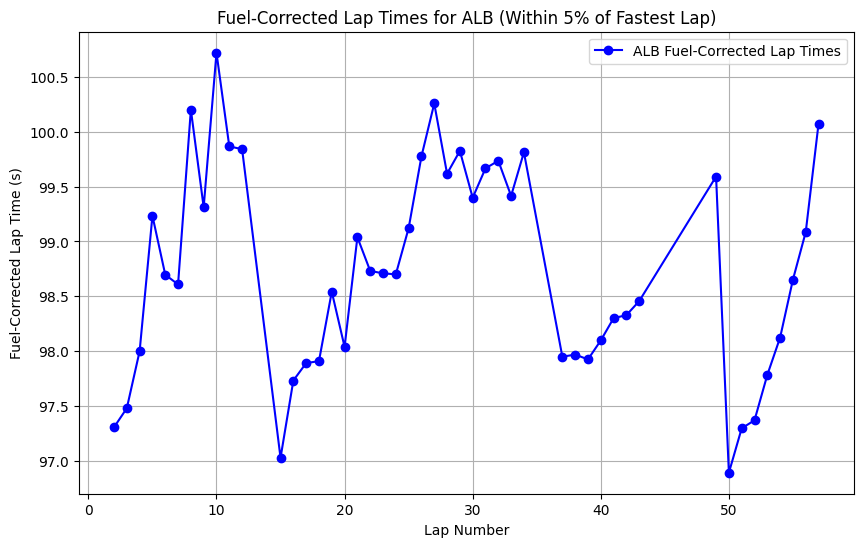

In [56]:
import matplotlib.pyplot as plt

# Filter the DataFrame for the specific driver (e.g., 'ALB')
df_alb = df[df['driver_short'] == 'ALB']

# Plotting
plt.figure(figsize=(10, 6))

# Plot fuel-corrected lap times for ALB
plt.plot(df_alb['lap_num'], df_alb['fuel_corrected_lap_time'], 
		 label='ALB Fuel-Corrected Lap Times', marker='o', linestyle='-', color='blue')

# Add labels and title
plt.xlabel('Lap Number')
plt.ylabel('Fuel-Corrected Lap Time (s)')
plt.title(f"Fuel-Corrected Lap Times for ALB (Within {5}% of Fastest Lap)")
plt.legend()
plt.grid(True)
plt.show()

## Step 4) Normalise by taking away fastest lap for driver

In [57]:
def normalise_lap_times(df):
	# Group by driver and calculate the fastest lap time for each driver
	df['fastest_lap_time'] = df.groupby('driver_short')['fuel_corrected_lap_time'].transform('min')

	# Normalise lap times by subtracting the fastest lap time
	df['normalised_lap_time'] = df['fuel_corrected_lap_time'] - df['fastest_lap_time']

	# Drop the fastest_lap_time as it's no longer needed
	df = df.drop(columns=['fastest_lap_time'])

	return df

df = normalise_lap_times(df)

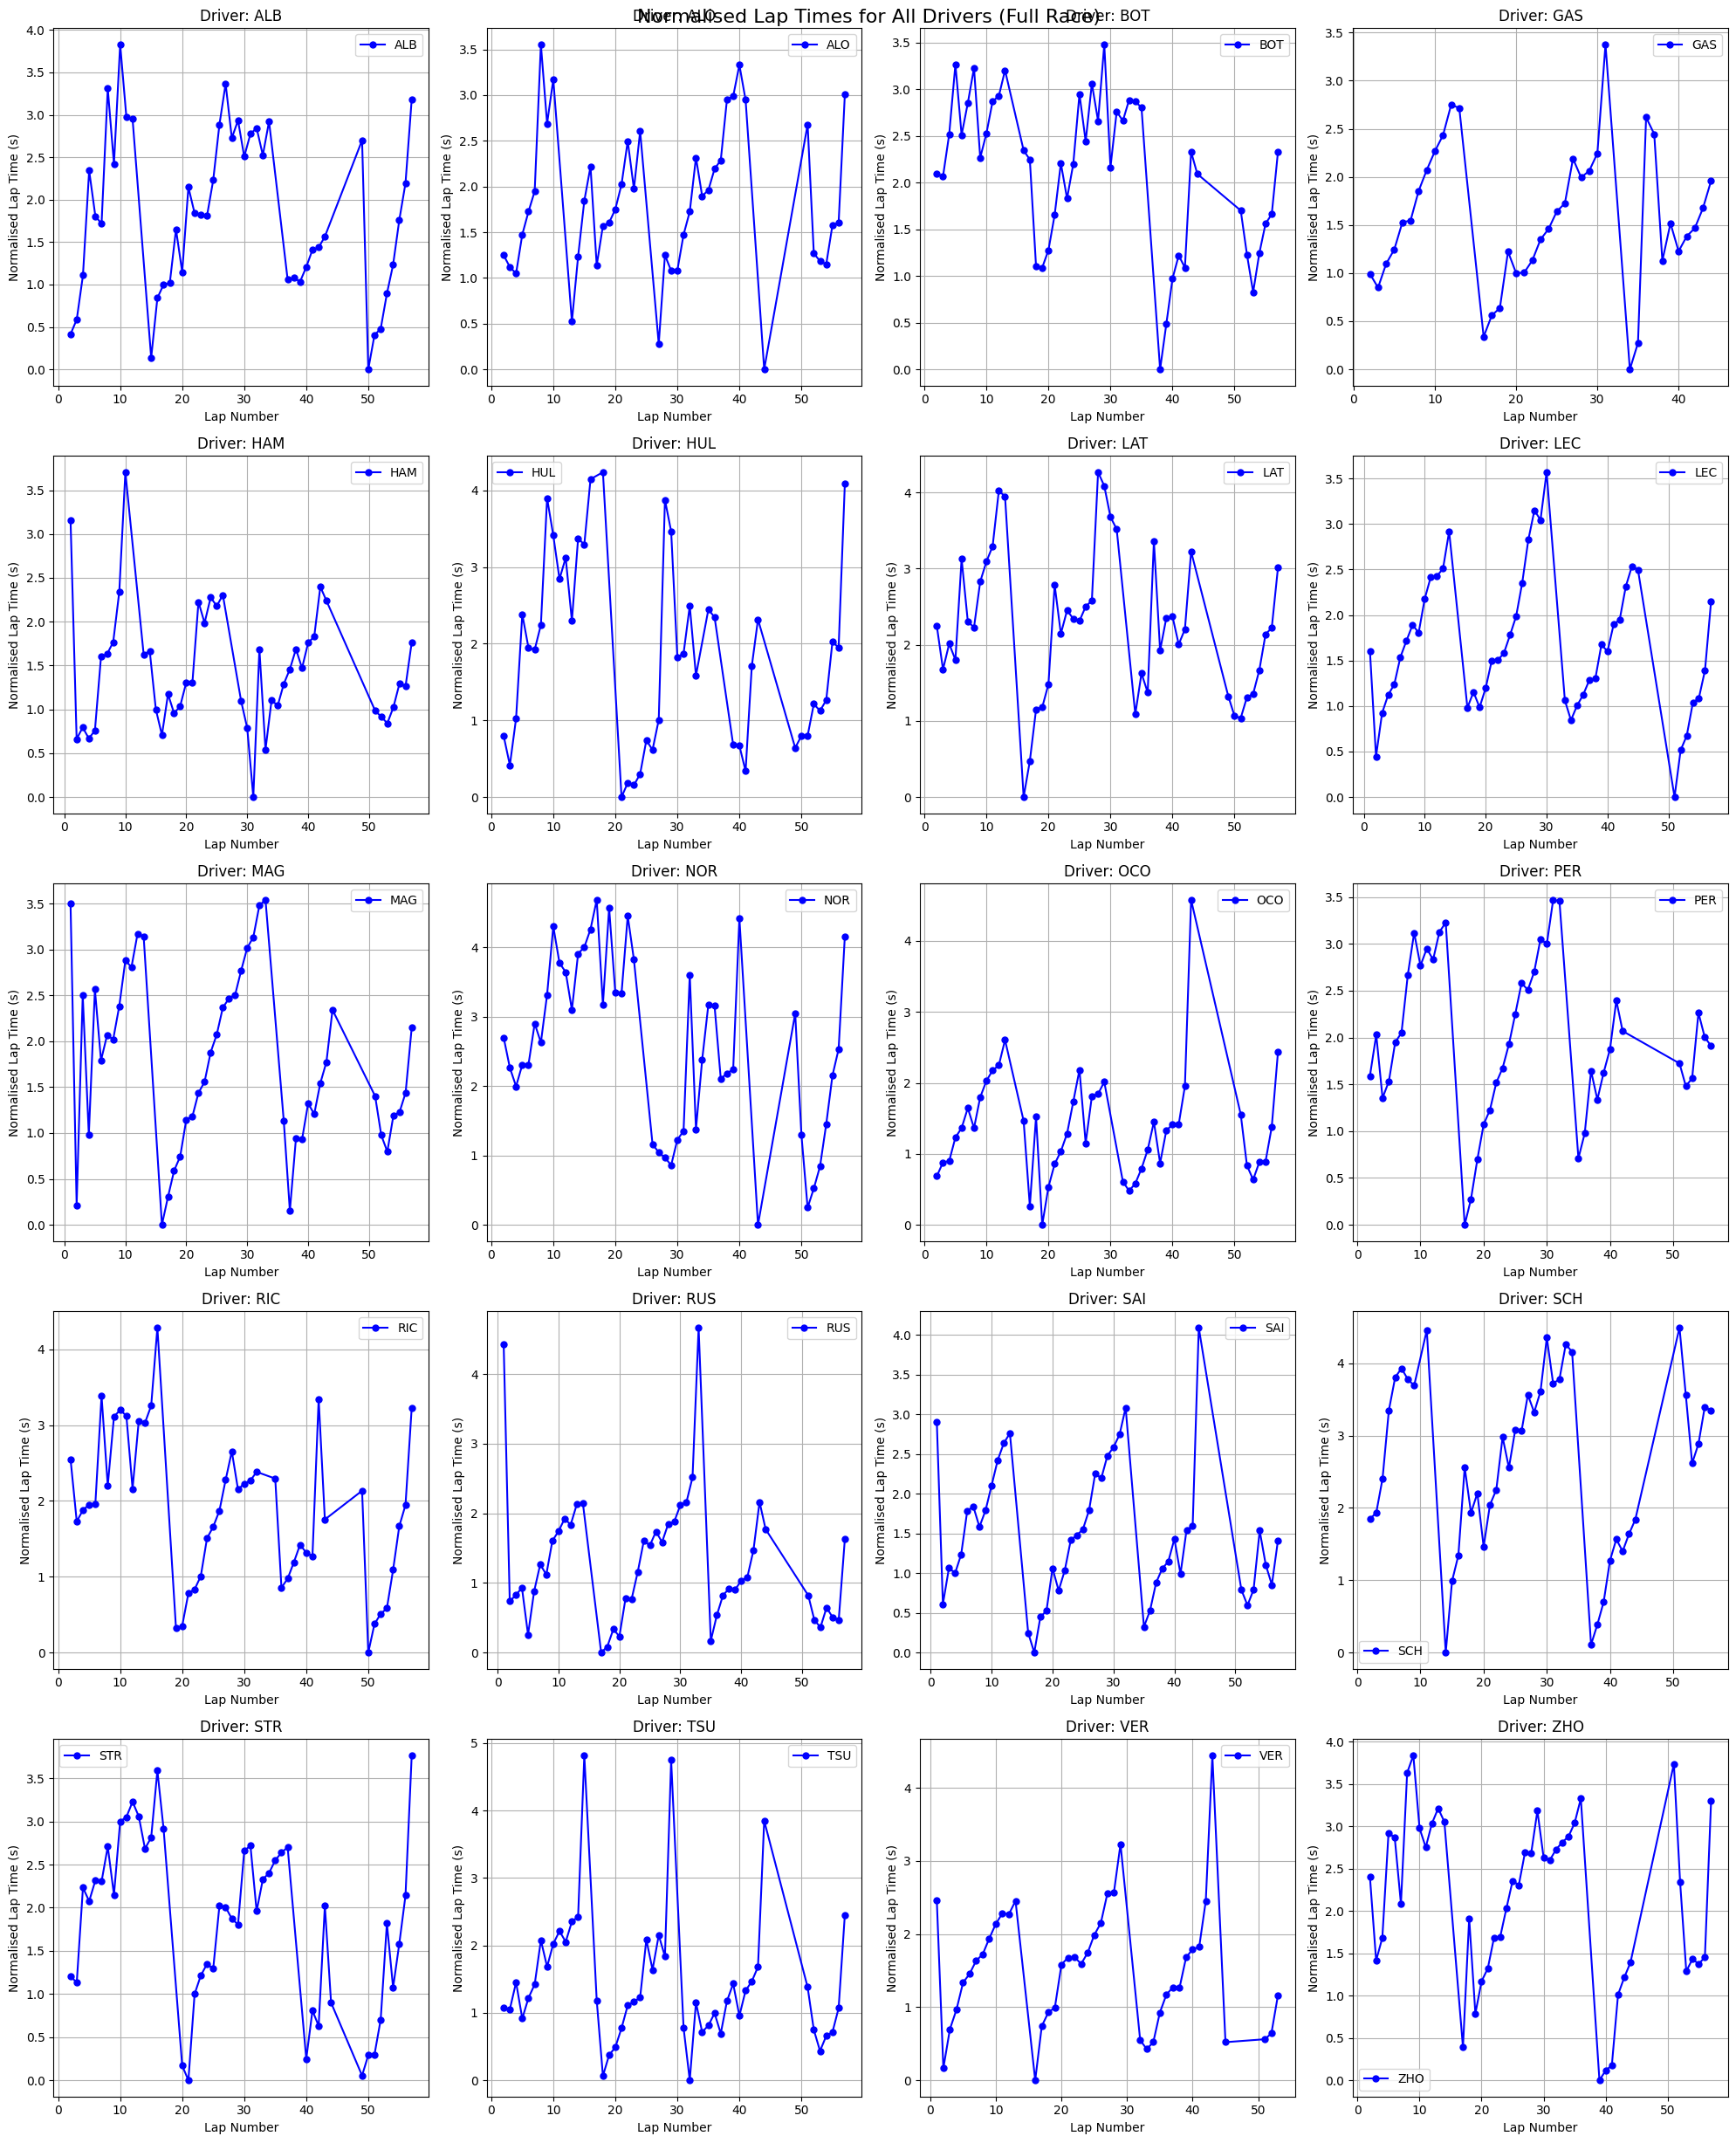

In [58]:
import matplotlib.pyplot as plt

# Normalise lap times
df = normalise_lap_times(df)

# Get the list of all drivers
drivers = df['driver_short'].unique()

# Calculate the number of rows and columns for the grid
num_drivers = len(drivers)
num_cols = 4  # Number of columns in the grid
num_rows = (num_drivers + num_cols - 1) // num_cols  # Calculate rows needed

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
fig.suptitle('Normalised Lap Times for All Drivers (Full Race)', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot Normalised lap times for each driver
for i, driver in enumerate(drivers):
	driver_data = df[df['driver_short'] == driver]
	ax = axes[i]
	ax.plot(driver_data['lap_num'], driver_data['normalised_lap_time'], 
			label=driver, marker='o', linestyle='-', markersize=5, color='blue')
	ax.set_xlabel('Lap Number')
	ax.set_ylabel('Normalised Lap Time (s)')
	ax.set_title(f'Driver: {driver}')
	ax.grid(True)
	ax.legend()

# Hide unused subplots
for j in range(i + 1, num_rows * num_cols):
	axes[j].axis('off')

plt.tight_layout()
plt.show()

## Step 5) Curves

In [59]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def calculate_tyre_degradation_curves(df):
	"""
	Calculate polynomial curves (degree 2) for tyre degradation for each driver in the race.
	Only uses stints with at least 6 laps for Tyre Type 1, 12 laps for Tyre Type 2, and 20 laps for Tyre Type 3.

	Parameters:
		df (pd.DataFrame): The DataFrame containing lap data for the full race.

	Returns:
		dict: A nested dictionary where:
			  - Key 1: Driver short code (e.g., 'ALB').
			  - Key 2: Tyre type (e.g., 'Soft', 'Medium', 'Hard').
			  - Value: A tuple of coefficients (a, b, c) for the polynomial ax^2 + bx + c.
	"""
	# Normalize lap times
	df = normalise_lap_times(df)

	# Get the list of all drivers
	drivers = df['driver_short'].unique()

	# Dictionary to store the results
	degradation_curves = {}

	# Define minimum laps required for each tyre type
	min_laps_by_tyre = {
		# 1: 8,    # Tyre Type 1 (e.g., Soft)
		# 2: 15,    # Tyre Type 2 (e.g., Medium)
		# 3: 23     # Tyre Type 3 (e.g., Hard)
	}

	# Process each driver
	for driver in drivers:
		# Filter data for the current driver
		df_driver = df[df['driver_short'] == driver]

		# Group by tyre type
		tyre_types = df_driver['tyre'].unique()

		# Dictionary to store polynomial coefficients for each tyre type
		tyre_coefficients = {tyre: [] for tyre in tyre_types}

		# Fit polynomial curves for each tyre type
		for tyre in tyre_types:
			tyre_data = df_driver[df_driver['tyre'] == tyre]

			# Group by stint to handle multiple stints with the same tyre type
			for stint, stint_data in tyre_data.groupby('stint'):
				# Check if the stint meets the minimum lap requirement for the tyre type
				min_laps = min_laps_by_tyre.get(tyre, 0)  # Default to 0 if tyre type not in dictionary
				if len(stint_data) < min_laps:
					print(f"Skipping stint for {driver} on {tyre} tyres: Only {len(stint_data)} laps (minimum {min_laps} required).")
					continue

				x = stint_data['tyre_laps'].values.reshape(-1, 1)  # Tyre laps as x-axis
				y = stint_data['normalised_lap_time'].values       # Normalized lap times as y-axis

				# Fit a polynomial of degree 2
				poly = PolynomialFeatures(degree=2)
				x_poly = poly.fit_transform(x)
				model = LinearRegression()
				model.fit(x_poly, y)

				# Store the coefficients (a, b, c) for the polynomial ax^2 + bx + c
				coefficients = [model.coef_[2], model.coef_[1], model.intercept_]  # [a, b, c]
				tyre_coefficients[tyre].append(coefficients)

		# Average coefficients for each tyre type
		averaged_coefficients = {}
		for tyre, coefficients_list in tyre_coefficients.items():
			if coefficients_list:  # Check if there are coefficients for this tyre type
				averaged_coefficients[tyre] = np.mean(coefficients_list, axis=0)

		# Store the averaged coefficients in the result dictionary
		degradation_curves[driver] = averaged_coefficients

	return degradation_curves

degradation_curves = (calculate_tyre_degradation_curves(df))

for driver, tyre_data in degradation_curves.items():
	print(f"Driver: {driver}")
	for tyre, coefficients in tyre_data.items():
		a, b, c = coefficients
		print(f"  Tyre: {tyre}, Coefficients (a, b, c): ({a:.4f}, {b:.4f}, {c:.4f})")

Driver: ALB
  Tyre: 1, Coefficients (a, b, c): (0.0482, -0.8051, 5.0465)
  Tyre: 2, Coefficients (a, b, c): (0.0012, 0.1362, 0.3884)
Driver: ALO
  Tyre: 1, Coefficients (a, b, c): (0.0099, 0.0458, 0.3849)
  Tyre: 2, Coefficients (a, b, c): (-0.0026, 0.1618, 0.7136)
  Tyre: 3, Coefficients (a, b, c): (-0.0030, 0.2378, 0.1472)
Driver: BOT
  Tyre: 1, Coefficients (a, b, c): (0.0441, -0.8804, 6.3095)
  Tyre: 2, Coefficients (a, b, c): (-0.0043, 0.2705, 0.2632)
Driver: GAS
  Tyre: 1, Coefficients (a, b, c): (0.0036, 0.1086, 0.2038)
  Tyre: 2, Coefficients (a, b, c): (0.0050, 0.0571, 0.3945)
  Tyre: 3, Coefficients (a, b, c): (-0.0261, 0.4549, -0.2204)
Driver: HAM
  Tyre: 1, Coefficients (a, b, c): (0.0728, -1.1643, 5.7888)
  Tyre: 3, Coefficients (a, b, c): (0.0190, -0.2693, 2.0917)
  Tyre: 2, Coefficients (a, b, c): (0.0073, -0.0191, 0.8031)
Driver: HUL
  Tyre: 1, Coefficients (a, b, c): (0.0132, 0.0114, 0.7192)
  Tyre: 2, Coefficients (a, b, c): (0.2099, -1.2484, 2.3587)
Driver: LAT
  Tyr

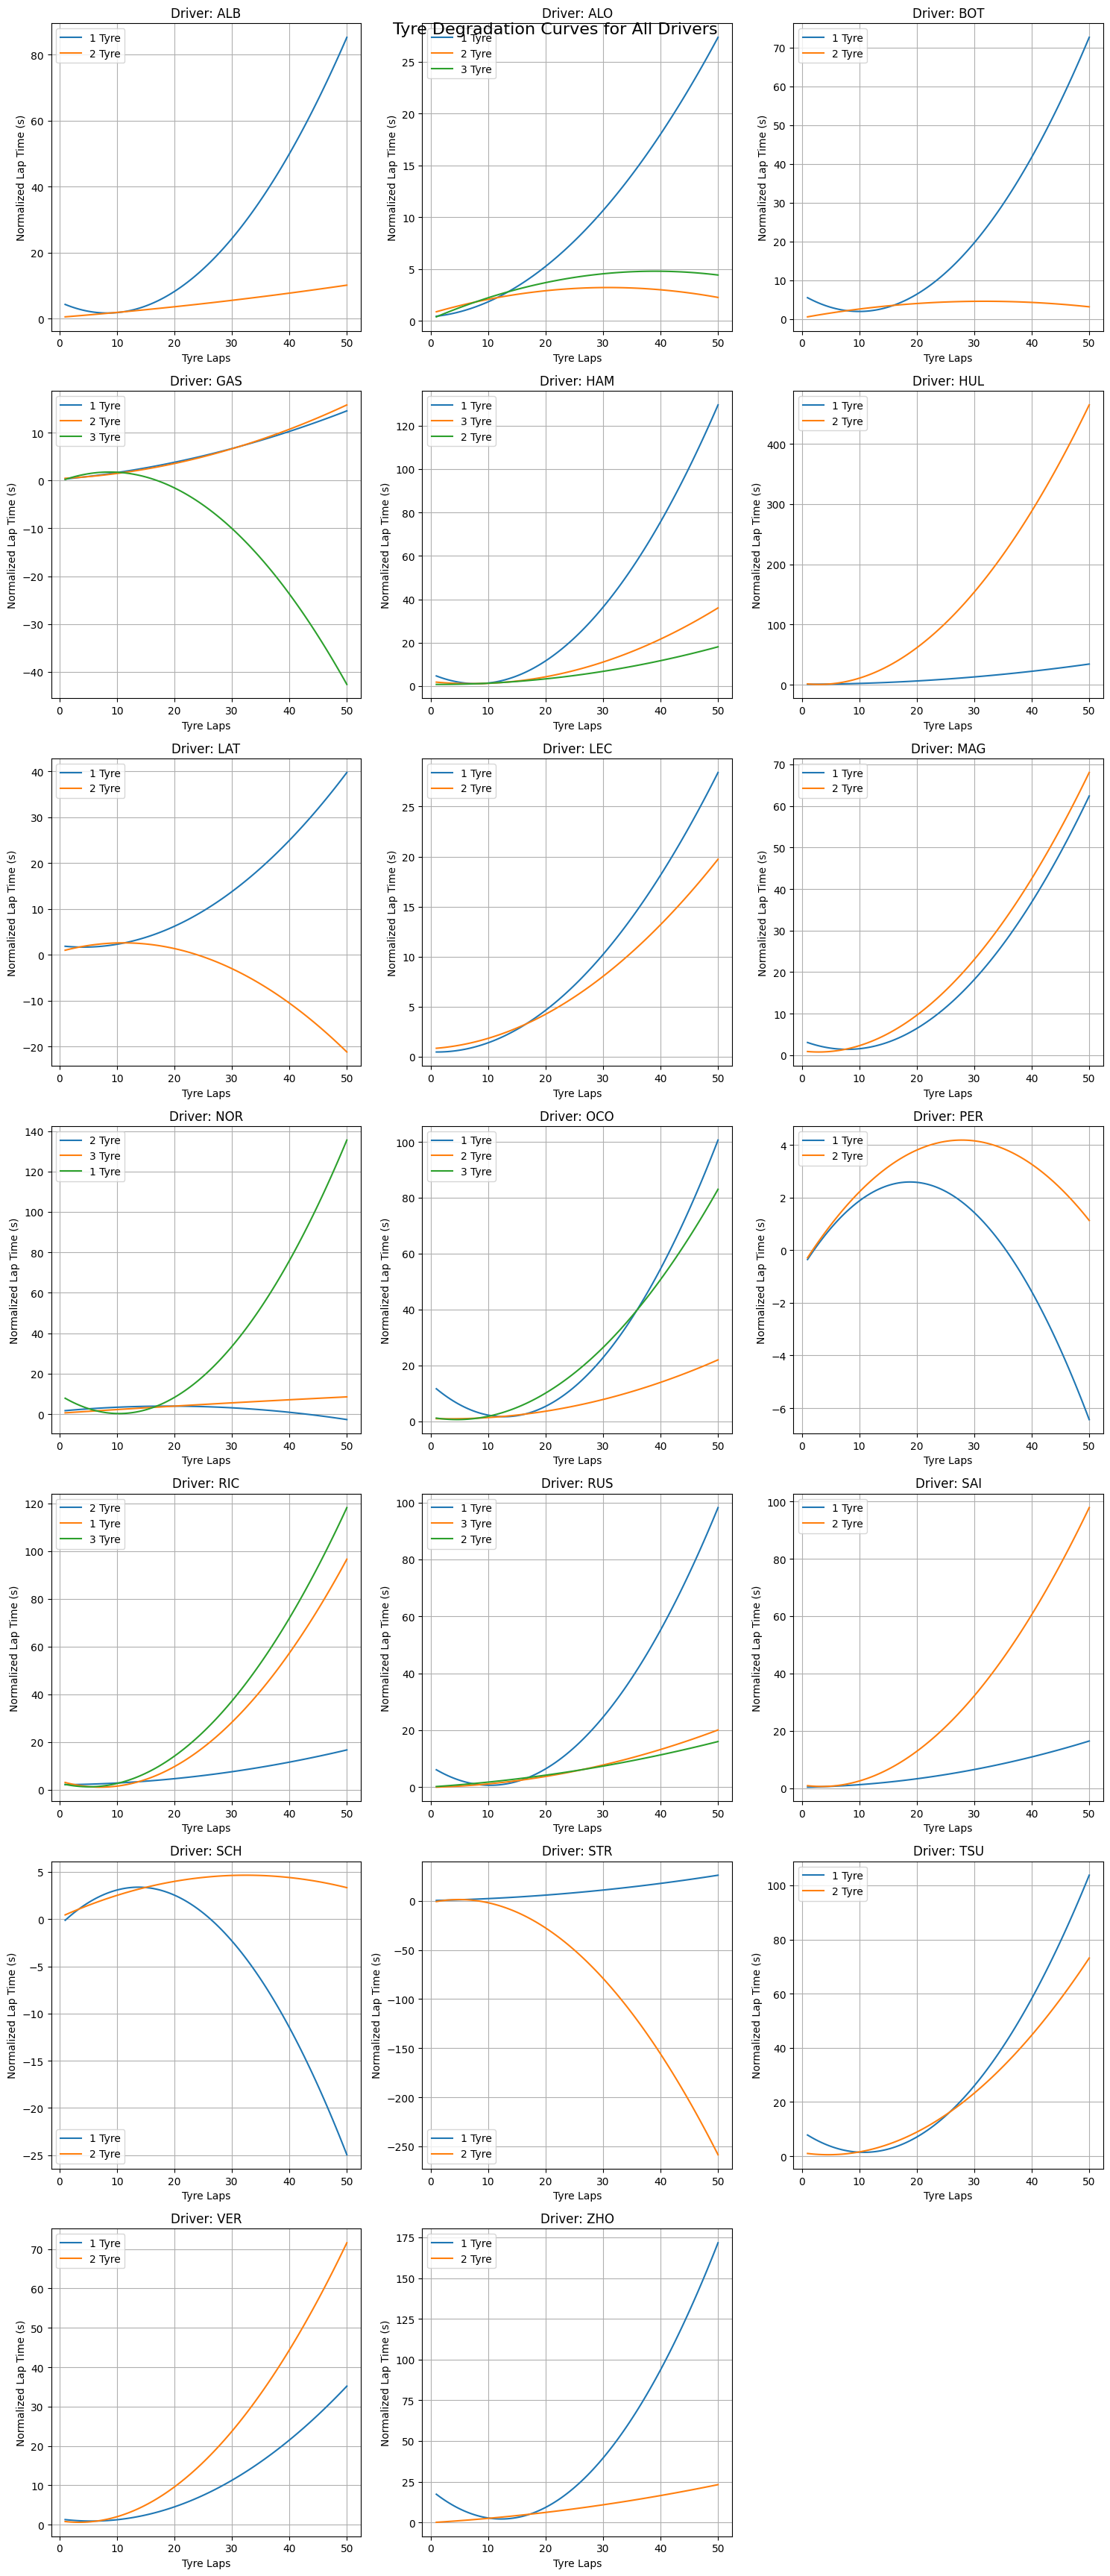

In [60]:
import matplotlib.pyplot as plt

def plot_tyre_degradation_curves_from_dict(degradation_curves):
	"""
	Plot tyre degradation curves for each driver using the output dictionary from
	`calculate_tyre_degradation_curves`.

	Parameters:
		degradation_curves (dict): A nested dictionary where:
								   - Key 1: Driver short code (e.g., 'ALB').
								   - Key 2: Tyre type (e.g., 'Soft', 'Medium', 'Hard').
								   - Value: A tuple of coefficients (a, b, c) for the polynomial ax^2 + bx + c.
	"""
	# Get the list of all drivers
	drivers = degradation_curves.keys()

	# Create a grid of subplots
	num_drivers = len(drivers)
	num_cols = 3  # Number of columns in the grid
	num_rows = (num_drivers + num_cols - 1) // num_cols  # Calculate rows needed

	fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
	fig.suptitle('Tyre Degradation Curves for All Drivers', fontsize=16)

	# Flatten the axes array for easy iteration
	axes = axes.flatten()

	# Plot curves for each driver
	for i, driver in enumerate(drivers):
		ax = axes[i]
		tyre_data = degradation_curves[driver]

		# Generate x values for plotting
		x_vals = np.linspace(1, 50, 100)  # Assume a maximum of 50 tyre laps for plotting

		# Plot curves for each tyre type
		for tyre, coefficients in tyre_data.items():
			if tyre == 4 or tyre == 5:
				continue
			a, b, c = coefficients
			y_vals = a * x_vals**2 + b * x_vals + c  # Calculate y values using the polynomial
			ax.plot(x_vals, y_vals, label=f'{tyre} Tyre')

		# Add labels and title for the subplot
		ax.set_xlabel('Tyre Laps')
		ax.set_ylabel('Normalized Lap Time (s)')
		ax.set_title(f'Driver: {driver}')
		ax.grid(True)
		ax.legend()

	# Hide unused subplots
	for j in range(i + 1, num_rows * num_cols):
		axes[j].axis('off')

	plt.tight_layout()
	plt.show()
	
plot_tyre_degradation_curves_from_dict(degradation_curves)

Processing round 0...
Processing round 1...


/tmp/ipykernel_2865/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)
/tmp/ipykernel_2865/4025736411.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_filter_driver_laps).reset_index(drop=True)


Processing round 2...


/tmp/ipykernel_2865/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)
/tmp/ipykernel_2865/4025736411.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_filter_driver_laps).reset_index(drop=True)


Processing round 3...


/tmp/ipykernel_2865/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)
/tmp/ipykernel_2865/4025736411.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_filter_driver_laps).reset_index(drop=True)


Processing round 4...


/tmp/ipykernel_2865/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)
/tmp/ipykernel_2865/4025736411.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_filter_driver_laps).reset_index(drop=True)


Processing round 5...


/tmp/ipykernel_2865/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)
/tmp/ipykernel_2865/4025736411.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_filter_driver_laps).reset_index(drop=True)


Processing round 6...


/tmp/ipykernel_2865/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)
/tmp/ipykernel_2865/4025736411.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_filter_driver_laps).reset_index(drop=True)


Processing round 7...


/tmp/ipykernel_2865/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)
/tmp/ipykernel_2865/4025736411.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_filter_driver_laps).reset_index(drop=True)


Processing round 8...


/tmp/ipykernel_2865/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)
/tmp/ipykernel_2865/4025736411.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_filter_driver_laps).reset_index(drop=True)


Processing round 9...


/tmp/ipykernel_2865/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)
/tmp/ipykernel_2865/4025736411.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_filter_driver_laps).reset_index(drop=True)


Processing round 10...


/tmp/ipykernel_2865/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)
/tmp/ipykernel_2865/4025736411.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_filter_driver_laps).reset_index(drop=True)


Processing round 11...


/tmp/ipykernel_2865/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)
/tmp/ipykernel_2865/4025736411.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_filter_driver_laps).reset_index(drop=True)


Processing round 12...


/tmp/ipykernel_2865/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)
/tmp/ipykernel_2865/4025736411.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_filter_driver_laps).reset_index(drop=True)


Processing round 13...


/tmp/ipykernel_2865/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)
/tmp/ipykernel_2865/4025736411.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_filter_driver_laps).reset_index(drop=True)


Processing round 14...


/tmp/ipykernel_2865/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)
/tmp/ipykernel_2865/4025736411.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_filter_driver_laps).reset_index(drop=True)


Processing round 15...


/tmp/ipykernel_2865/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)
/tmp/ipykernel_2865/4025736411.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_filter_driver_laps).reset_index(drop=True)


Processing round 16...


/tmp/ipykernel_2865/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)
/tmp/ipykernel_2865/4025736411.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_filter_driver_laps).reset_index(drop=True)


Processing round 17...


/tmp/ipykernel_2865/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)
/tmp/ipykernel_2865/4025736411.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_filter_driver_laps).reset_index(drop=True)


Processing round 18...


/tmp/ipykernel_2865/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)
/tmp/ipykernel_2865/4025736411.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_filter_driver_laps).reset_index(drop=True)


Processing round 19...


/tmp/ipykernel_2865/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)
/tmp/ipykernel_2865/4025736411.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_filter_driver_laps).reset_index(drop=True)


Processing round 20...


/tmp/ipykernel_2865/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)
/tmp/ipykernel_2865/4025736411.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_filter_driver_laps).reset_index(drop=True)


Processing round 21...


/tmp/ipykernel_2865/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)
/tmp/ipykernel_2865/4025736411.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_filter_driver_laps).reset_index(drop=True)



Plotting averaged degradation curves for 2022 season:


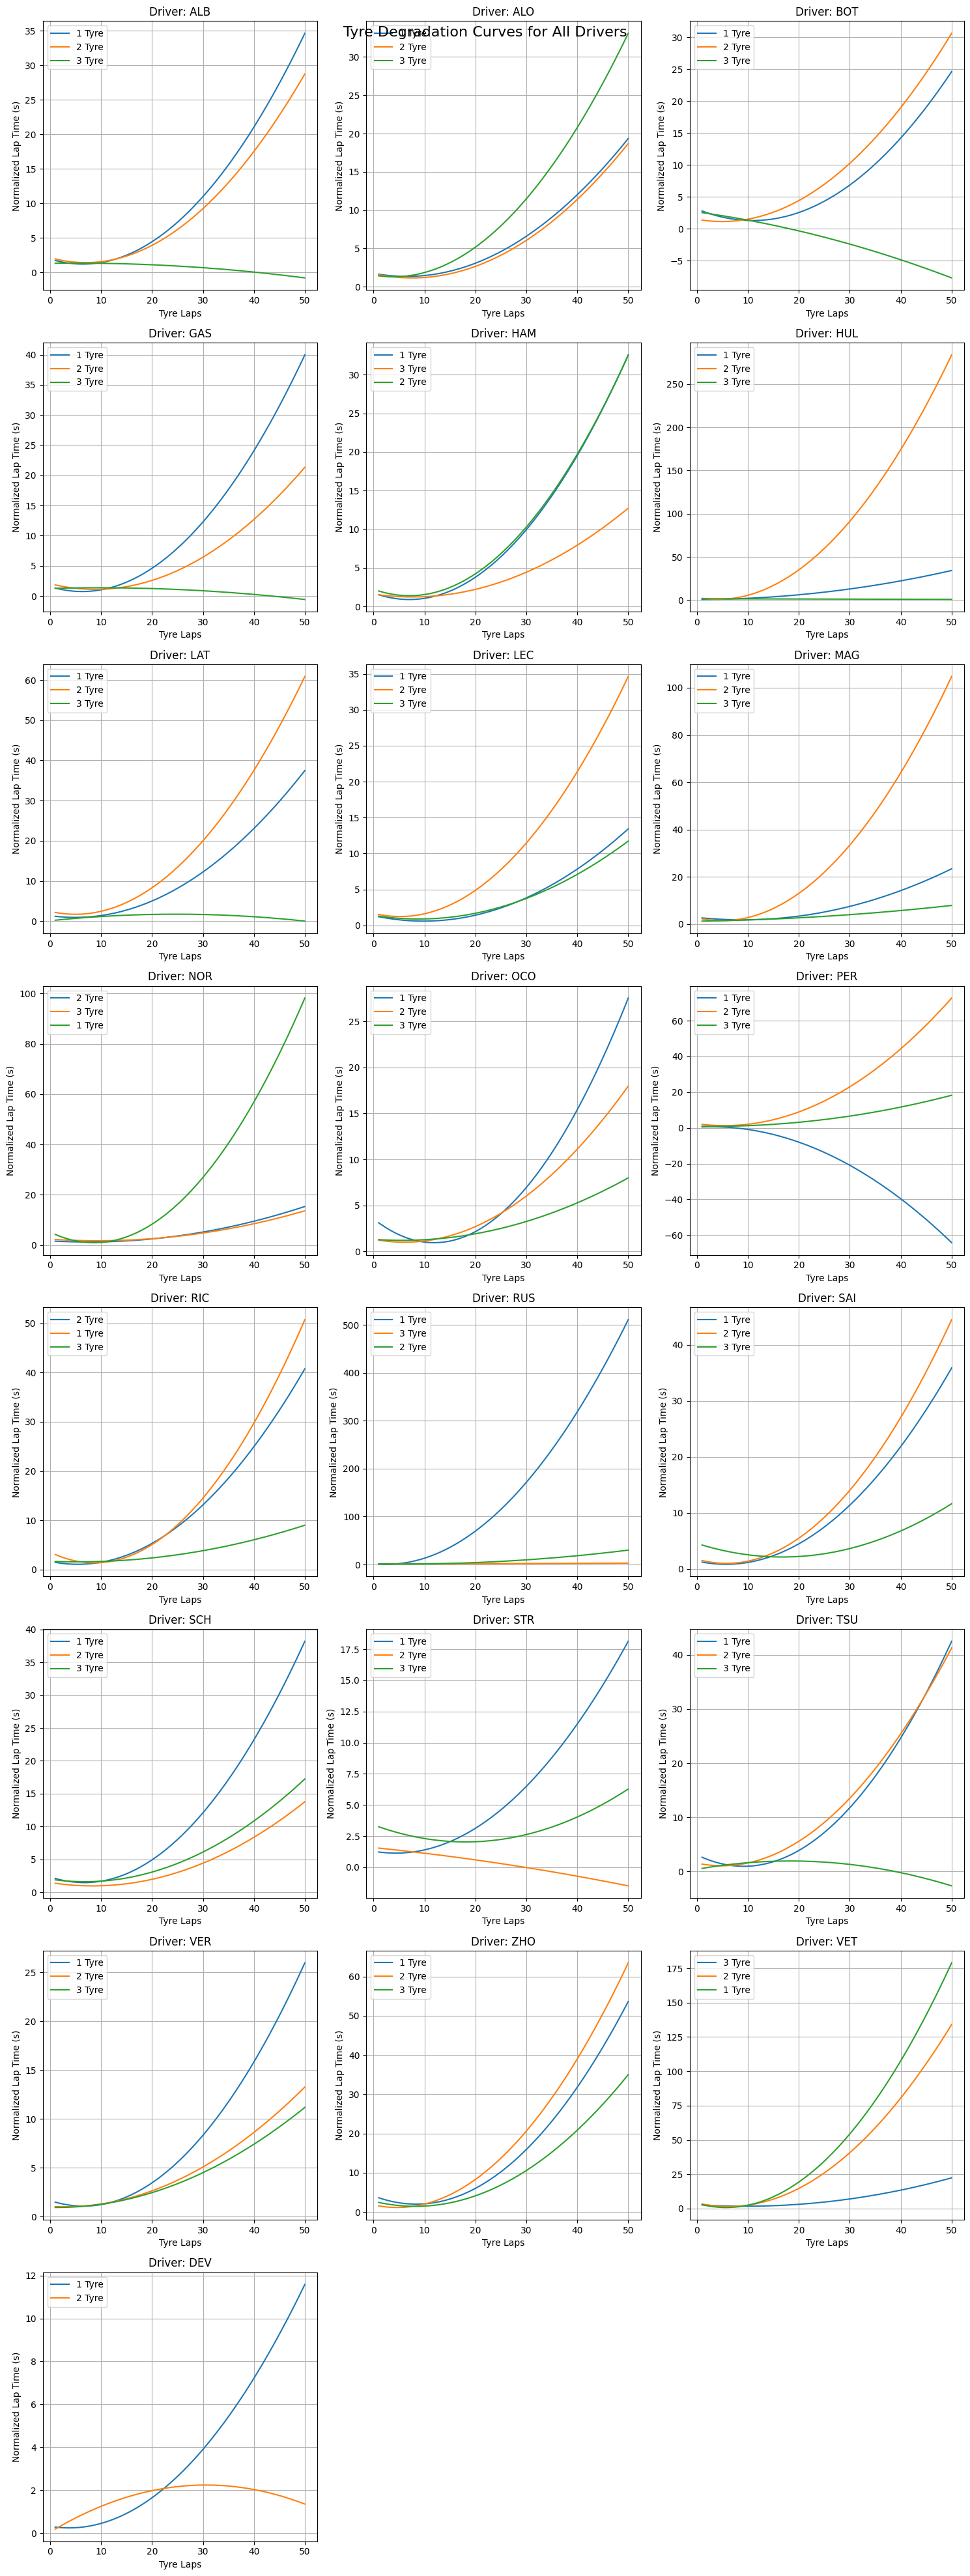

In [61]:
# Step 1: Load all 2022 data (remove round filter)
df_full_season = create_dataframe()
df_full_season = df_full_season[df_full_season['year'] == 2022]

# Step 2: Initialize storage for aggregated coefficients
all_season_curves = {}

# Get list of all rounds in 2022
all_rounds = df_full_season['round'].unique() - 1

# Step 3: Process each race
for race_round in all_rounds:
	print(f"Processing round {race_round}...")
	
	# Filter race data
	df_race = df_full_season[df_full_season['round'] == race_round]
	df_race = df_race[df_race['session_type'] == 'Race']
	
	# Skip if no race data
	if df_race.empty:
		continue
		
	# Process pipeline
	try:
		df_race = assign_stint_numbers(df_race)
		df_race = correct_fuel_effect(df_race)
		df_race = remove_laps_outside_percent(df_race)
		df_race = normalise_lap_times(df_race)
		
		# Get degradation curves for this race
		race_curves = calculate_tyre_degradation_curves(df_race)
		
		# Aggregate results
		for driver, tyre_data in race_curves.items():
			if driver not in all_season_curves:
				all_season_curves[driver] = {}
				
			for tyre, coeffs in tyre_data.items():
				if tyre not in all_season_curves[driver]:
					all_season_curves[driver][tyre] = []
				all_season_curves[driver][tyre].append(coeffs)
				
	except Exception as e:
		print(f"Error processing round {race_round}: {str(e)}")
		continue

# Step 4: Average coefficients across all races
averaged_season_curves = {}
for driver, tyre_data in all_season_curves.items():
	averaged_season_curves[driver] = {}
	
	for tyre, coeff_list in tyre_data.items():
		# Convert list of coefficient arrays to 2D array
		coeff_array = np.array(coeff_list)
		
		# Calculate mean coefficients (ignore NaN values)
		mean_coeffs = np.nanmean(coeff_array, axis=0)
		
		# Handle cases where all values might be NaN
		if np.any(np.isnan(mean_coeffs)):
			print(f"Warning: Insufficient data for {driver} on {tyre} tyres")
			continue
			
		averaged_season_curves[driver][tyre] = mean_coeffs

# Step 5: Plot averaged curves
print("\nPlotting averaged degradation curves for 2022 season:")
plot_tyre_degradation_curves_from_dict(averaged_season_curves)

In [62]:
def predict_race_times(df, averaged_season_curves, max_fuel_kg=110, fuel_effect_per_kg=0.03):
	"""
	Predict race times for each driver using the averaged tyre degradation curves and fuel effect.

	Parameters:
		df (pd.DataFrame): The DataFrame containing lap data for the full race.
		averaged_season_curves (dict): The averaged tyre degradation curves for each driver.
		max_fuel_kg (float): Maximum fuel load at the start of the race (default: 110 kg).
		fuel_effect_per_kg (float): Time penalty per kg of fuel (default: 0.03 seconds).

	Returns:
		dict: A dictionary where the key is the driver short code and the value is the predicted race time.
	"""
	# Initialize dictionary to store predicted race times
	predicted_race_times = {}

	# Process each driver
	for driver, tyre_data in averaged_season_curves.items():
		# Filter data for the current driver
		df_driver = df[df['driver_short'] == driver]

		# Initialize predicted race time
		predicted_time = 0

		# Iterate through each lap
		for lap_num, lap_data in df_driver.iterrows():
			tyre = lap_data['tyre']
			tyre_laps = lap_data['tyre_laps']

			# Get the coefficients for the current tyre type
			if tyre in tyre_data:
				a, b, c = tyre_data[tyre]
			else:
				print(f"Warning: No degradation curve found for {driver} on {tyre} tyres.")
				continue

			# Predict normalized lap time using the polynomial
			normalized_lap_time = a * tyre_laps**2 + b * tyre_laps + c

			# Add fuel effect
			fuel_weight = max_fuel_kg - (lap_data['lap_num'] - 1) * (max_fuel_kg / df_driver['lap_num'].max())
			fuel_correction = fuel_weight * fuel_effect_per_kg

			# Calculate predicted lap time
			fastest_lap_time = df_driver['fuel_corrected_lap_time'].min()
			predicted_lap_time = fastest_lap_time + normalized_lap_time + fuel_correction

			# Add to total predicted race time
			predicted_time += predicted_lap_time

		# Store the predicted race time for the driver
		predicted_race_times[driver] = predicted_time

	return predicted_race_times

	

def calculate_actual_race_times(df):
	"""
	Calculate the actual total race time for each driver.

	Parameters:
		df (pd.DataFrame): The DataFrame containing lap data for the full race.

	Returns:
		dict: A dictionary where the key is the driver short code and the value is the actual total race time.
	"""
	# Group by driver and sum the lap times
	actual_race_times = df.groupby('driver_short')['lap_time'].sum().to_dict()
	return actual_race_times


df = create_dataframe()
df1 = df[(df['year'] == 2022) & (df['round'] == 22)]

# Calculate actual race times

df1 = correct_fuel_effect(df1)
actual_race_times = calculate_actual_race_times(df1)
predicted_race_times = predict_race_times(df1, averaged_season_curves)

total_absolute_difference = 0

# Loop through each driver and calculate the absolute difference
for driver, predicted_time in predicted_race_times.items():
    actual_time = actual_race_times.get(driver, None)
    if actual_time is not None:
        difference = abs(predicted_time - actual_time)
        total_absolute_difference += difference
        # print(f"Driver: {driver}, Predicted Race Time: {predicted_time:.2f} seconds, "
        #       f"Actual Race Time: {actual_time:.2f} seconds, Difference: {difference:.2f} seconds")
    else:
        print(f"Driver: {driver}, Actual race time not found.")

# Print the total absolute difference
print(f"Total Absolute Difference: {total_absolute_difference:.2f} seconds")



df2 = df[(df['year'] == 2022) & (df['round'] == 3)]

# Calculate actual race times
df2 = correct_fuel_effect(df2)

actual_race_times = calculate_actual_race_times(df2)
predicted_race_times = predict_race_times(df2, averaged_season_curves)

total_absolute_difference = 0

# Loop through each driver and calculate the absolute difference
for driver, predicted_time in predicted_race_times.items():
    actual_time = actual_race_times.get(driver, None)
    if actual_time is not None:
        difference = abs(predicted_time - actual_time)
        total_absolute_difference += difference
        # print(f"Driver: {driver}, Predicted Race Time: {predicted_time:.2f} seconds, "
        #       f"Actual Race Time: {actual_time:.2f} seconds, Difference: {difference:.2f} seconds")
    else:
        print(f"Driver: {driver}, Actual race time not found.")

# Print the total absolute difference
print(f"Total Absolute Difference: {total_absolute_difference:.2f} seconds")


df3 = df[(df['year'] == 2022) & (df['round'] == 7)]
df3 = correct_fuel_effect(df3)

# Calculate actual race times
actual_race_times = calculate_actual_race_times(df3)
predicted_race_times = predict_race_times(df3, averaged_season_curves)

total_absolute_difference = 0

# Loop through each driver and calculate the absolute difference
for driver, predicted_time in predicted_race_times.items():
    actual_time = actual_race_times.get(driver, None)
    if actual_time is not None:
        difference = abs(predicted_time - actual_time)
        total_absolute_difference += difference
        # print(f"Driver: {driver}, Predicted Race Time: {predicted_time:.2f} seconds, "
        #       f"Actual Race Time: {actual_time:.2f} seconds, Difference: {difference:.2f} seconds")
    else:
        print(f"Driver: {driver}, Actual race time not found.")

# Print the total absolute difference
print(f"Total Absolute Difference: {total_absolute_difference:.2f} seconds")

/tmp/ipykernel_2865/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)


Driver: HUL, Actual race time not found.
Driver: DEV, Actual race time not found.
Total Absolute Difference: 26157.27 seconds


/tmp/ipykernel_2865/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)


Driver: HUL, Actual race time not found.
Driver: DEV, Actual race time not found.
Total Absolute Difference: 31641.37 seconds


/tmp/ipykernel_2865/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)


Driver: HUL, Actual race time not found.
Driver: DEV, Actual race time not found.
Total Absolute Difference: 44063.95 seconds


KeyError: 'fuel_corrected_lap_time'

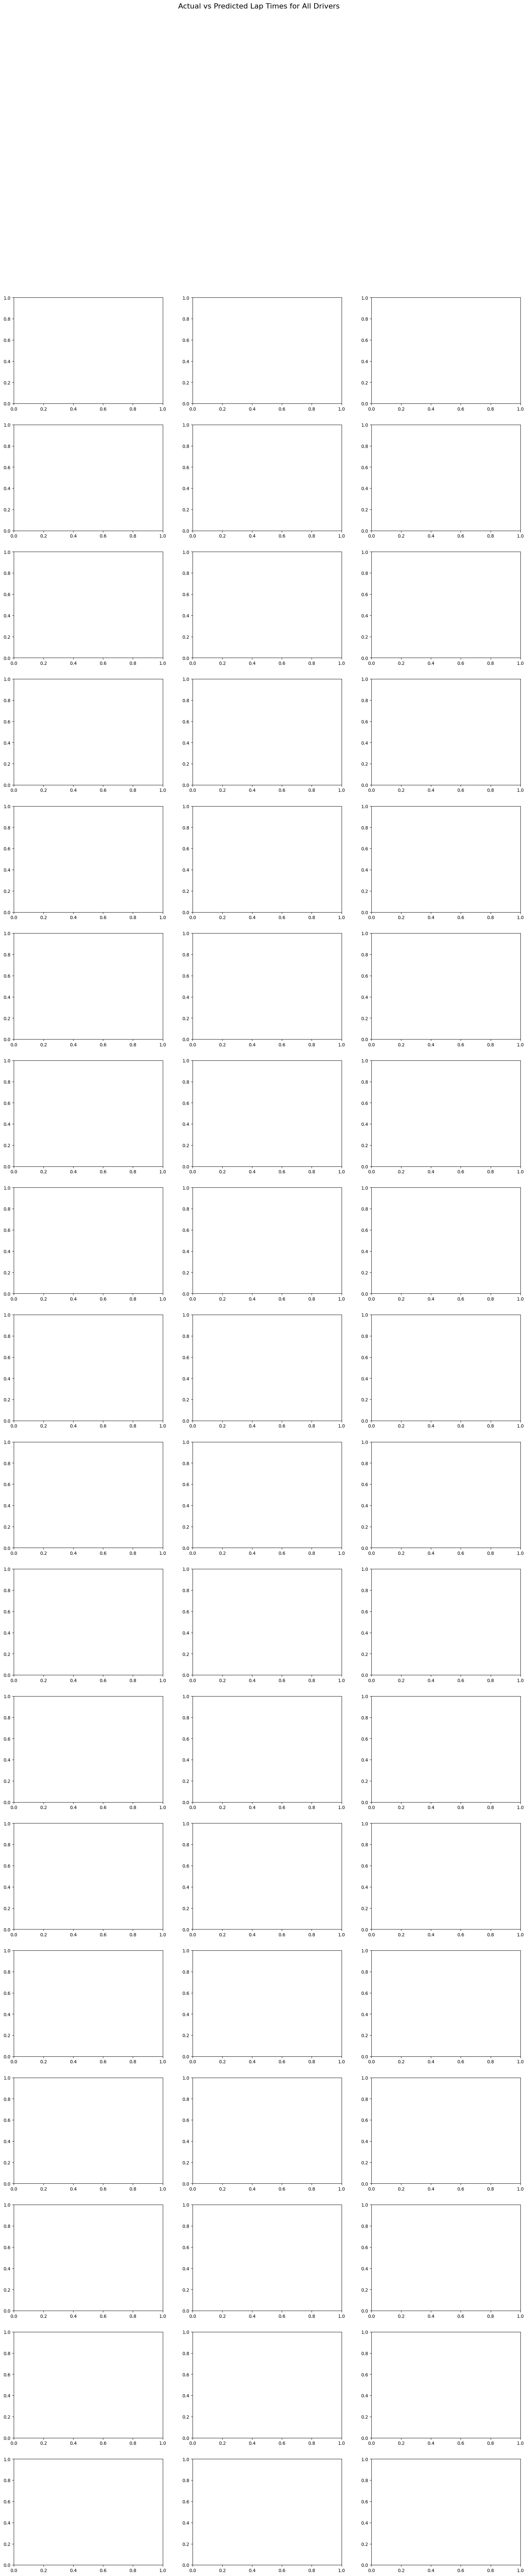

In [63]:
import matplotlib.pyplot as plt

def plot_actual_vs_predicted_lap_times(df, predicted_race_times, averaged_season_curves, max_fuel_kg=110, fuel_effect_per_kg=0.03):
	"""
	Plot actual vs predicted lap times for each driver.

	Parameters:
		df (pd.DataFrame): The DataFrame containing lap data for the full race.
		predicted_race_times (dict): The predicted race times for each driver.
		averaged_season_curves (dict): The averaged tyre degradation curves for each driver.
		max_fuel_kg (float): Maximum fuel load at the start of the race (default: 110 kg).
		fuel_effect_per_kg (float): Time penalty per kg of fuel (default: 0.03 seconds).
	"""
	# Get the list of all drivers
	drivers = df['driver_short'].unique()

	df = df[df['driver_short'] != 'HUL']
	
	# Create a grid of subplots
	num_drivers = len(drivers)
	num_cols = 3  # Number of columns in the grid
	num_rows = (num_drivers + num_cols - 1) // num_cols  # Calculate rows needed

	fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
	fig.suptitle('Actual vs Predicted Lap Times for All Drivers', fontsize=16)

	# Flatten the axes array for easy iteration
	axes = axes.flatten()

	# Plot actual vs predicted lap times for each driver
	for i, driver in enumerate(drivers):
		ax = axes[i]

		# Filter data for the current driver
		df_driver = df[df['driver_short'] == driver]

		# Initialize lists to store predicted lap times
		predicted_lap_times = []

		# Iterate through each lap to calculate predicted lap times
		for lap_num, lap_data in df_driver.iterrows():
			tyre = lap_data['tyre']
			tyre_laps = lap_data['tyre_laps']

			# Get the coefficients for the current tyre type
			if tyre in averaged_season_curves[driver]:
				a, b, c = averaged_season_curves[driver][tyre]
			else:
				print(f"Warning: No degradation curve found for {driver} on {tyre} tyres.")
				continue

			# Predict normalized lap time using the polynomial
			normalized_lap_time = a * tyre_laps**2 + b * tyre_laps + c

			# Add fuel effect
			fuel_weight = max_fuel_kg - (lap_data['lap_num'] - 1) * (max_fuel_kg / df_driver['lap_num'].max())
			fuel_correction = fuel_weight * fuel_effect_per_kg

			# Calculate predicted lap time
			fastest_lap_time = df_driver['fuel_corrected_lap_time'].min()
			predicted_lap_time = fastest_lap_time + normalized_lap_time + fuel_correction

			# Store predicted lap time
			predicted_lap_times.append(predicted_lap_time)

		# Plot actual lap times
		ax.plot(df_driver['lap_num'], df_driver['lap_time'], label='Actual Lap Time', marker='o', linestyle='-', color='blue')

		# Plot predicted lap times
		ax.plot(df_driver['lap_num'], predicted_lap_times, label='Predicted Lap Time', marker='x', linestyle='--', color='red')

		# Add labels and title for the subplot
		ax.set_xlabel('Lap Number')
		ax.set_ylabel('Lap Time (s)')
		ax.set_title(f'Driver: {driver}')
		ax.grid(True)
		ax.legend()

	# Hide unused subplots
	for j in range(i + 1, num_rows * num_cols):
		axes[j].axis('off')

	plt.tight_layout()
	plt.show()
	
plot_actual_vs_predicted_lap_times(df, predicted_race_times, averaged_season_curves)


/tmp/ipykernel_18661/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)
/tmp/ipykernel_18661/4025736411.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_filter_driver_laps).reset_index(drop=True)
/tmp/ipykernel_18661/3790536989.py:13: DeprecationWarning: DataFrameGro

Skipping stint for RUS on 1 tyres: Only 7 laps (minimum 8 required).
Skipping stint for RUS on 3 tyres: Only 17 laps (minimum 23 required).
Skipping stint for RUS on 2 tyres: Only 10 laps (minimum 15 required).
Skipping stint for RUS on 2 tyres: Only 14 laps (minimum 15 required).
Skipping stint for RUS on 2 tyres: Only 11 laps (minimum 15 required).
Skipping stint for RUS on 2 tyres: Only 13 laps (minimum 15 required).
Skipping stint for RUS on 3 tyres: Only 1 laps (minimum 23 required).


/tmp/ipykernel_18661/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)
/tmp/ipykernel_18661/4025736411.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_filter_driver_laps).reset_index(drop=True)
/tmp/ipykernel_18661/3790536989.py:13: DeprecationWarning: DataFrameGro

Skipping stint for RUS on 2 tyres: Only 7 laps (minimum 15 required).
Skipping stint for RUS on 3 tyres: Only 18 laps (minimum 23 required).
Skipping stint for RUS on 2 tyres: Only 9 laps (minimum 15 required).
Skipping stint for RUS on 2 tyres: Only 9 laps (minimum 15 required).
Skipping stint for RUS on 2 tyres: Only 14 laps (minimum 15 required).
Skipping stint for RUS on 3 tyres: Only 14 laps (minimum 23 required).
Skipping stint for RUS on 2 tyres: Only 6 laps (minimum 15 required).
Skipping stint for RUS on 3 tyres: Only 15 laps (minimum 23 required).


/tmp/ipykernel_18661/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)
/tmp/ipykernel_18661/4025736411.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_filter_driver_laps).reset_index(drop=True)
/tmp/ipykernel_18661/3790536989.py:13: DeprecationWarning: DataFrameGro

Skipping stint for RUS on 3 tyres: Only 22 laps (minimum 23 required).
Skipping stint for RUS on 1 tyres: Only 3 laps (minimum 8 required).
Skipping stint for RUS on 1 tyres: Only 3 laps (minimum 8 required).
Skipping stint for RUS on 2 tyres: Only 13 laps (minimum 15 required).
Skipping stint for RUS on 3 tyres: Only 14 laps (minimum 23 required).
Skipping stint for RUS on 3 tyres: Only 17 laps (minimum 23 required).
Skipping stint for RUS on 1 tyres: Only 1 laps (minimum 8 required).
Skipping stint for RUS on 1 tyres: Only 1 laps (minimum 8 required).
Skipping stint for RUS on 2 tyres: Only 14 laps (minimum 15 required).


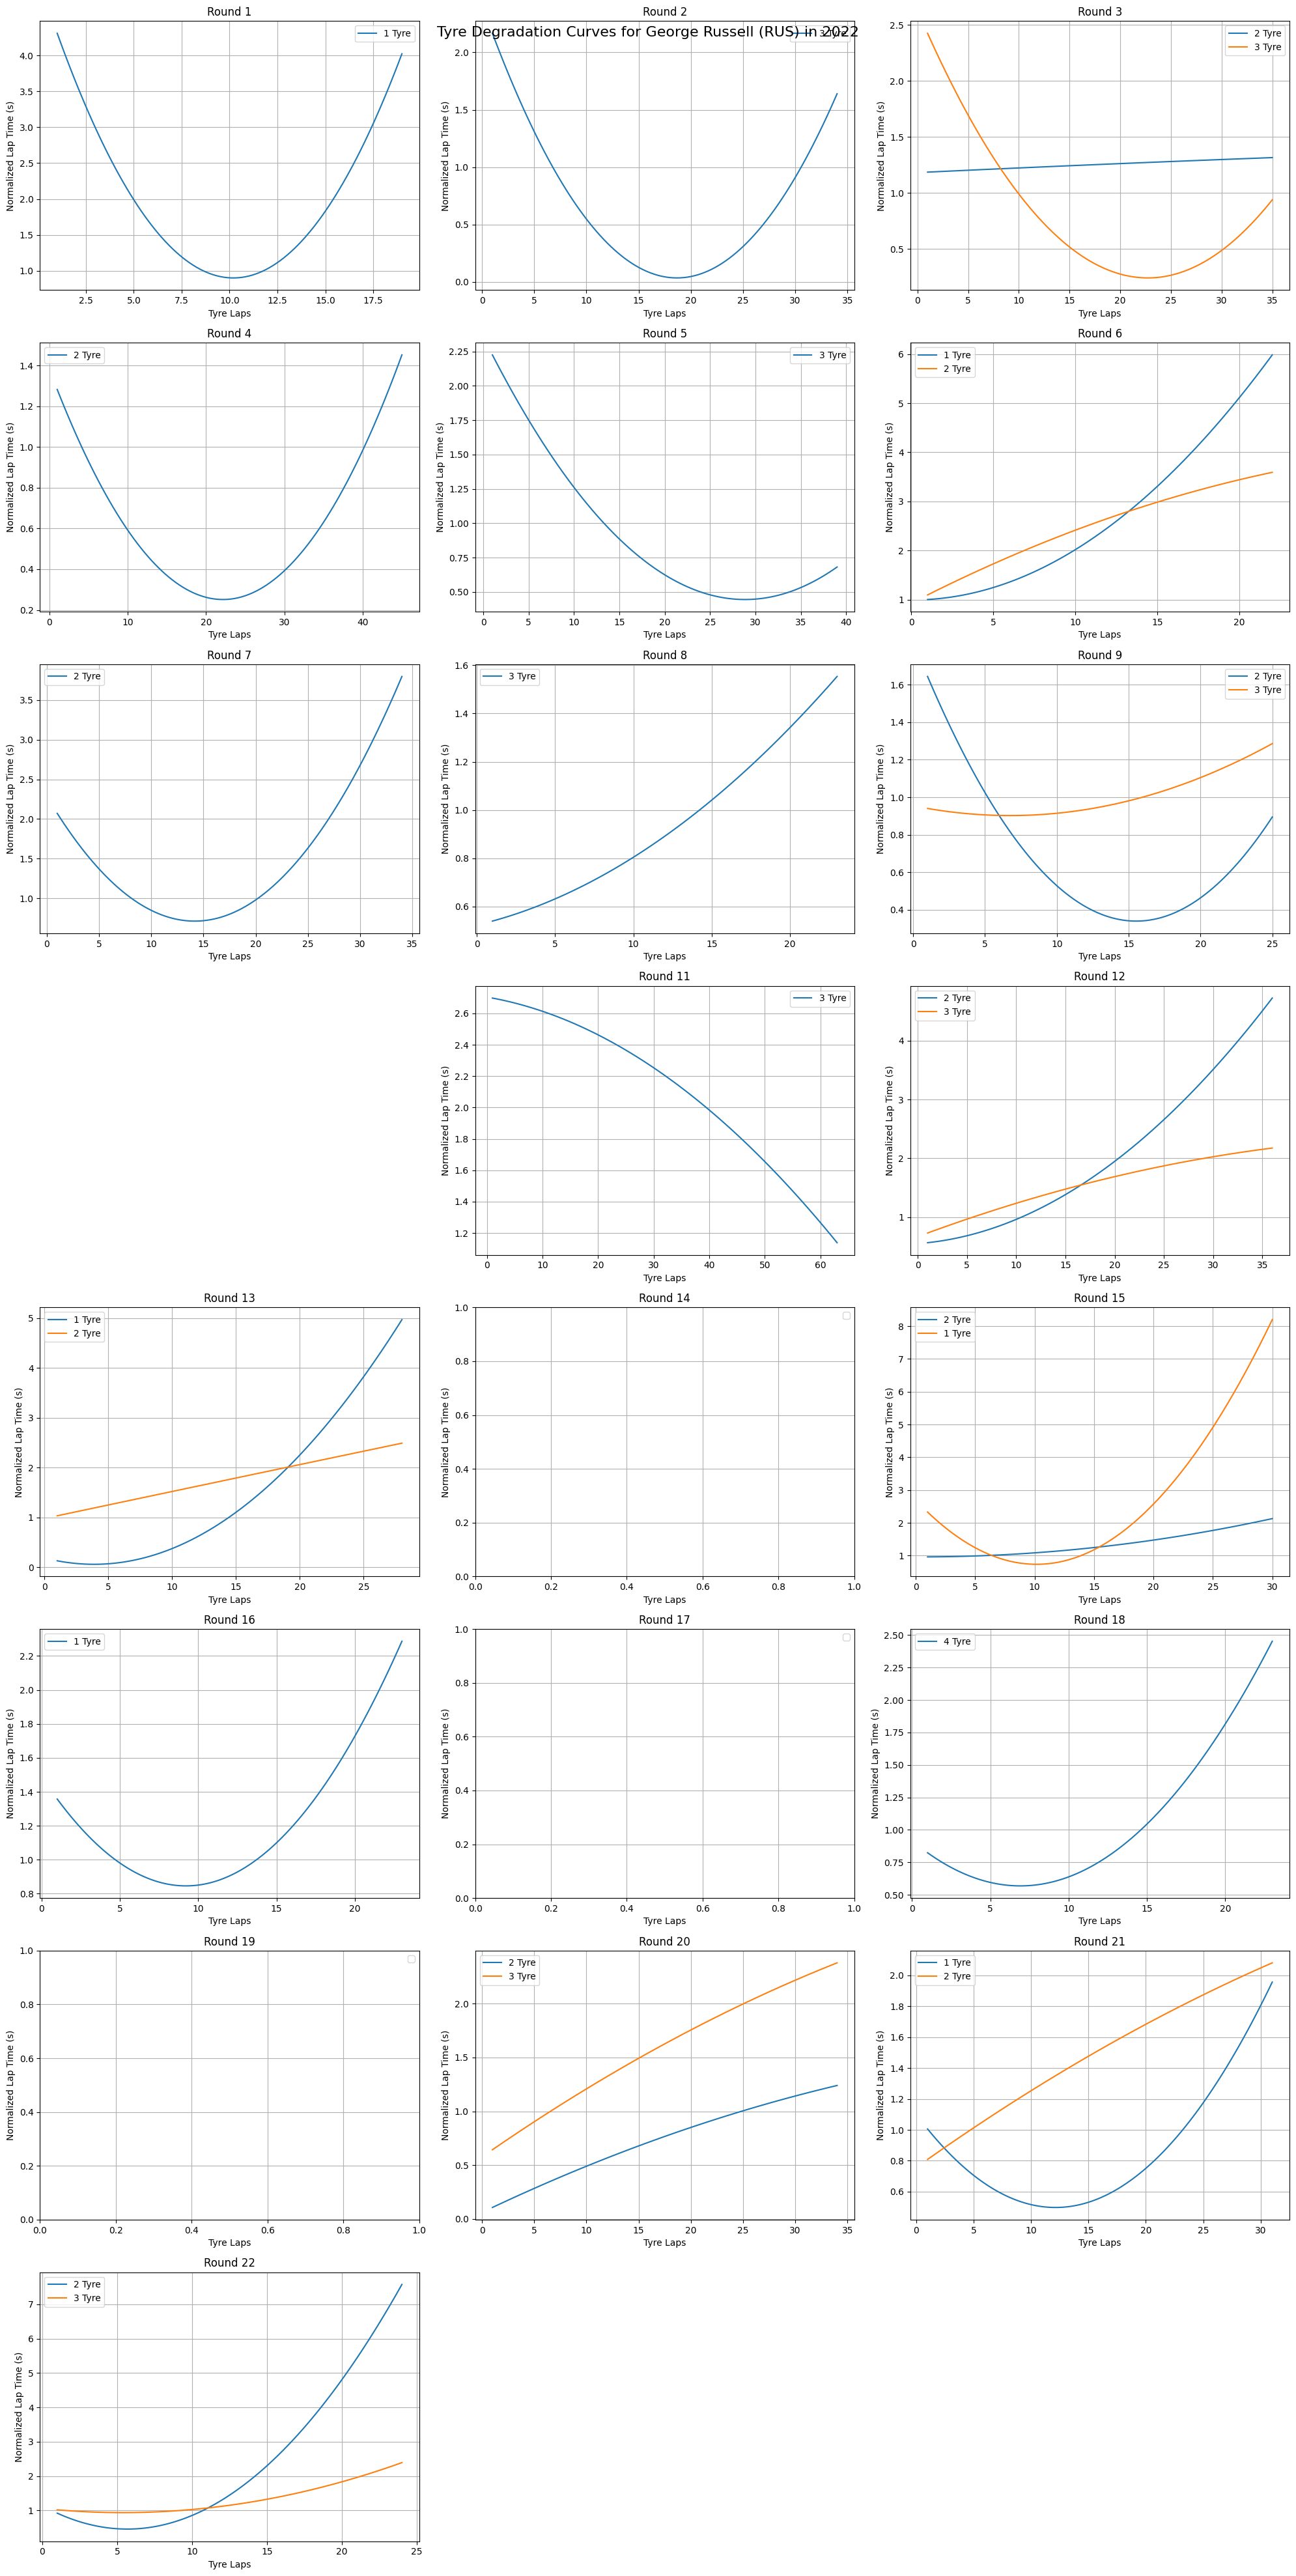

In [390]:
import matplotlib.pyplot as plt

# Load all 2022 data
df_full_season = create_dataframe()
df_full_season = df_full_season[df_full_season['year'] == 2022]

# Get list of all rounds in 2022
all_rounds = df_full_season['round'].unique()

# Filter data for George Russell (RUS)
df_rus = df_full_season[df_full_season['driver_short'] == 'RUS']

# Create a grid of subplots
num_races = len(all_rounds)
num_cols = 3  # Number of columns in the grid
num_rows = (num_races + num_cols - 1) // num_cols  # Calculate rows needed

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
fig.suptitle('Tyre Degradation Curves for George Russell (RUS) in 2022', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Process each race for RUS
for i, race_round in enumerate(all_rounds):
	ax = axes[i]

	# Filter race data for RUS
	df_race = df_rus[df_rus['round'] == race_round]
	df_race = df_race[df_race['session_type'] == 'Race']
	
	# Skip if no race data
	if df_race.empty:
		ax.axis('off')  # Hide unused subplot
		continue
		
	# Process pipeline
	try:
		df_race = assign_stint_numbers(df_race)
		df_race = correct_fuel_effect(df_race)
		df_race = remove_laps_outside_percent(df_race)
		df_race = normalise_lap_times(df_race)
		
		# Get degradation curves for this race
		race_curves = calculate_tyre_degradation_curves(df_race)
		
		# Plot curves for RUS
		if 'RUS' in race_curves:
			tyre_data = race_curves['RUS']
			x_vals = np.linspace(1, df_race['tyre_laps'].max(), 100)  # X values for plotting

			for tyre, coefficients in tyre_data.items():
				a, b, c = coefficients
				y_vals = a * x_vals**2 + b * x_vals + c  # Calculate y values using the polynomial
				ax.plot(x_vals, y_vals, label=f'{tyre} Tyre')

			# Add labels and title for the subplot
			ax.set_xlabel('Tyre Laps')
			ax.set_ylabel('Normalized Lap Time (s)')
			ax.set_title(f'Round {race_round}')
			ax.grid(True)
			ax.legend()
		else:
			ax.axis('off')  # Hide unused subplot
				
	except Exception as e:
		print(f"Error processing round {race_round}: {str(e)}")
		ax.axis('off')  # Hide unused subplot
		continue

# Hide unused subplots
for j in range(i + 1, num_rows * num_cols):
	axes[j].axis('off')

plt.tight_layout()
plt.show()

/tmp/ipykernel_18661/3790536989.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('driver_short').apply(_correct_fuel_for_driver).reset_index(drop=True)


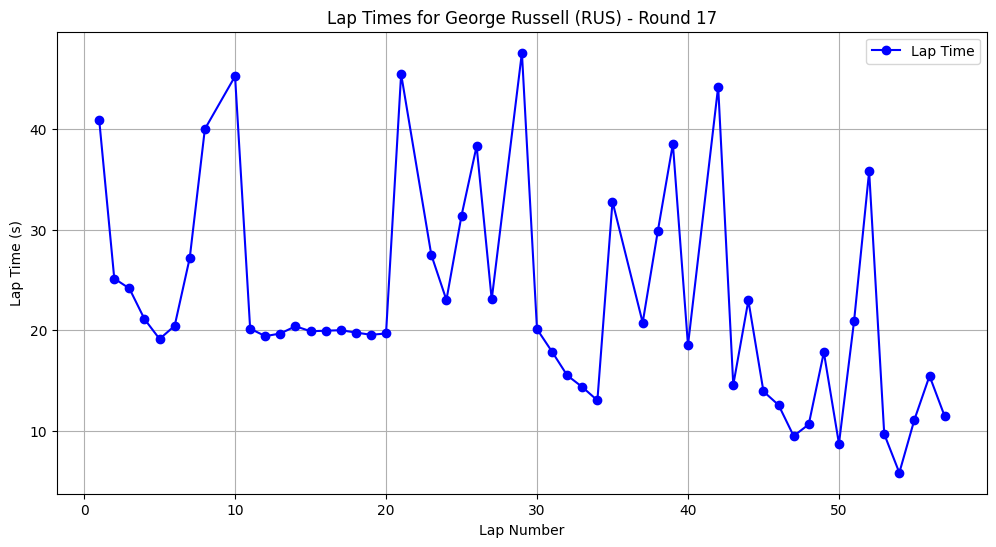

In [ ]:
import matplotlib.pyplot as plt

# Load all 2022 data
df_full_season = create_dataframe()
df_full_season = df_full_season[df_full_season['year'] == 2022]

# Filter data for George Russell (RUS) in Round 17
df_rus_round_17 = df_full_season[(df_full_season['driver_short'] == 'RUS') & (df_full_season['round'] == 17)]

df_rus_round_17 = correct_fuel_effect(df_rus_round_17)
df_rus_round_17 = normalise_lap_times(df_rus_round_17)
# Skip if no race data
if df_rus_round_17.empty:
	print("No race data found for RUS in Round 17.")
else:
	# Filter for race session only
	df_rus_round_17_race = df_rus_round_17[df_rus_round_17['session_type'] == 'Race']
	
	if df_rus_round_17_race.empty:
		print("No race session data found for RUS in Round 17.")
	else:
		# Plot lap times vs lap numbers
		plt.figure(figsize=(12, 6))
		plt.plot(df_rus_round_17_race['lap_num'], df_rus_round_17_race['normalised_lap_time'], 
				 label='Lap Time', marker='o', linestyle='-', color='blue')

		# Add labels and title
		plt.xlabel('Lap Number')
		plt.ylabel('Lap Time (s)')
		plt.title('Lap Times for George Russell (RUS) - Round 17')
		plt.grid(True)
		plt.legend()
		plt.show()

In [ ]:
df_rus_round_17[df_rus_round_17['session_type'] == 'Race']



,year,round,circuit_name,driver_name,driver_short,lap_num,lap_time,tyre,tyre_laps,pit,session_type,fuel_weight,fuel_correction,fuel_corrected_lap_time,normalised_lap_time
59,2022,17,Marina Bay,George Russell,RUS,1,144.570,4,1,True,Race,110.000000,3.300000,141.270000,40.906368
60,2022,17,Marina Bay,George Russell,RUS,2,128.743,4,2,False,Race,108.070175,3.242105,125.500895,25.137263
61,2022,17,Marina Bay,George Russell,RUS,3,127.696,4,3,False,Race,106.140351,3.184211,124.511789,24.148158
62,2022,17,Marina Bay,George Russell,RUS,4,124.604,4,4,False,Race,104.210526,3.126316,121.477684,21.114053
63,2022,17,Marina Bay,George Russell,RUS,5,122.566,4,5,False,Race,102.280702,3.068421,119.497579,19.133947
64,2022,17,Marina Bay,George Russell,RUS,6,123.817,4,6,False,Race,100.350877,3.010526,120.806474,20.442842
65,2022,17,Marina Bay,George Russell,RUS,7,130.503,4,7,False,Race,98.421053,2.952632,127.550368,27.186737
66,2022,17,Marina Bay,George Russell,RUS,8,143.222,4,8,False,Race,96.491228,2.894737,140.327263,39.963632
67,2022,17,Marina Bay,George Russell,RUS,10,148.349,4,10,False,Race,92.631579,2.778947,145.570053,45.206421
68,2022,17,Marina Bay,George Russell,RUS,11,123.247,4,11,False,Race,90.701754,2.721053,120.525947,20.162316
